In [0]:
import os; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Unsupervised Learning')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
from sklearn.utils import shuffle
from util import getKaggleMNIST
from autoencoder_tf import DNN

TensorFlow 1.x selected.


In [0]:
class RBM(object):
    def __init__(self, D, M, an_id):
        self.D = D
        self.M = M
        self.id = an_id
        self.build(D,M)

    def set_session(self, session):
        self.session = session

    def build(self, D, M):
        #params
        self.W = tf.Variable(tf.random_normal(shape=(D, M)) * np.sqrt(2.0 / M))
        #without limiting variance we may get numerical staiblity issues
        self.c = tf.Variable(np.zeros(M).astype(np.float32))
        self.b = tf.Variable(np.zeros(D).astype(np.float32))

        #data
        self.X_in = tf.placeholder(tf.float32, shape = (None, D))

        #conditional probabilities
        V = self.X_in
        p_h_given_v = tf.nn.sigmoid(tf.matmul(V, self.W) + self.c)
        self.p_h_given_v = p_h_given_v #save the variable for later
        r = tf.random_uniform(shape=tf.shape(p_h_given_v))
        H = tf.to_float(r < p_h_given_v) #convert probability to bernouilli binary values

        p_v_given_h = tf.nn.sigmoid(tf.matmul(H, tf.transpose(self.W)) + self.b)
        r = tf.random_uniform(shape=tf.shape(p_v_given_h))
        X_sample = tf.to_float(r < p_v_given_h)

        #build the objective function
        objective = tf.reduce_mean(self.free_energy(self.X_in)) - tf.reduce_mean(self.free_energy(X_sample))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(objective)
        # self.train_op = tf.train.GradientDescentOptimizer(1e-3).minimize(objective)

        #build the cost
        #we won't use this to optimize the model parameters
        #just to observe what happens during training
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X_in, logits=logits))

    def fit(self, X, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N // batch_sz
        
        costs = []
        print("Training rbm: %s" %self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz: (j*batch_sz + batch_sz)]
                _, c = self.session.run((self.train_op, self.cost), feed_dict={self.X_in: batch})
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)
                costs.append(c)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def free_energy(self, V):
        b = tf.reshape(self.b, (self.D, 1))
        first_term = -tf.matmul(V, b)
        first_term = tf.reshape(first_term, (-1,))

        second_term = -tf.reduce_sum(tf.nn.softplus(tf.matmul(V, self.W) + self.c), axis=1)

        return first_term + second_term



    def forward_hidden(self, X):
        return tf.nn.sigmoid(tf.matmul(X, self.W) + self.c)

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W) + self.b) 

    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.p_h_given_v, feed_dict={self.X_in:X})

def main():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()

    #same as autoencoder_tf.py
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    _, D = Xtrain.shape
    K = len(set(Ytrain))
    dnn = DNN(D, [1000, 750, 500], K, UnsupervisedModel=RBM)
    init_op = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init_op)
        dnn.set_session(session)
        dnn.fit(Xtrain, Ytrain, Xtest, Ytest, pretrain=True, epochs=10)


Training rbm: 0
epoch: 0
j / n_batches: 0 / 590 cost: 0.7305746
j / n_batches: 10 / 590 cost: 0.3374709
j / n_batches: 20 / 590 cost: 0.4312332
j / n_batches: 30 / 590 cost: 0.4176904
j / n_batches: 40 / 590 cost: 0.40737948
j / n_batches: 50 / 590 cost: 0.40476626
j / n_batches: 60 / 590 cost: 0.38575333
j / n_batches: 70 / 590 cost: 0.38842478
j / n_batches: 80 / 590 cost: 0.35333735
j / n_batches: 90 / 590 cost: 0.3663307
j / n_batches: 100 / 590 cost: 0.37552476
j / n_batches: 110 / 590 cost: 0.37120315
j / n_batches: 120 / 590 cost: 0.38037813
j / n_batches: 130 / 590 cost: 0.39259654
j / n_batches: 140 / 590 cost: 0.38630888
j / n_batches: 150 / 590 cost: 0.40002924
j / n_batches: 160 / 590 cost: 0.42166573
j / n_batches: 170 / 590 cost: 0.41255713
j / n_batches: 180 / 590 cost: 0.44166464
j / n_batches: 190 / 590 cost: 0.48479447
j / n_batches: 200 / 590 cost: 0.49563566
j / n_batches: 210 / 590 cost: 0.53925216
j / n_batches: 220 / 590 cost: 0.5067409
j / n_batches: 230 / 590 c

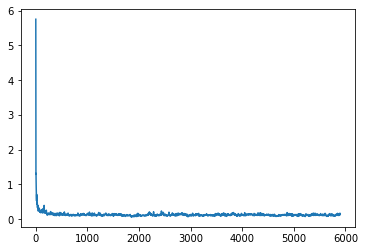

In [7]:
if __name__ == "__main__":
    main()
